<div style="color: #ffffff; background-color: #2979ff; border-bottom: 5px solid #004ecb; padding: 5em;">
<b style="font-size: 30pt;">Convex and Distributed Optimization Lab</b> <br> <br>
<b style="font-size: 10pt; color: #bbdefb">MSIAM — Université Grenoble Alpes — 2018/2019</b> <br>
<b style="font-size: 10pt; color: #bbdefb">Lecturers: Jérôme Malick, Yassine Laguel, Sélim Chraibi</b>
</div>

**Author(s): Begatim Bytyqi, Ilia Riabov , Ebba Ekblom

In [1]:
# Automatic reload of local libraries
%load_ext autoreload
%autoreload 2
%reload_ext autoreload
%matplotlib inline

>**[I. Introduction](#I.-Introduction)**<br> 
**[II. The optimization problem](#II.-The-optimization-problem)**<br>
**[III. Implementing the solvers](#III.-Implementing-the-solvers)**<br>
&nbsp; &nbsp; &nbsp;[GD (Gradient descent)](#GD-(Gradient-descent))<br>
&nbsp; &nbsp; &nbsp;[SGD (Stochastic Gradient Descent)](#SGD-(Stochastic-Gradient-Descent))<br>
&nbsp; &nbsp; &nbsp;[SAGA (Stochastic Average Gradient "Amélioré")](#SAGA-(Stochastic-Average-Gradient-"Amélioré"))<br>
&nbsp; &nbsp; &nbsp;[SVRG (Stochastic Variance Reduced Gradient)](#SVRG-(Stochastic-Variance-Reduced-Gradient))<br>
&nbsp; &nbsp; &nbsp;[Comparison](#Comparison)<br>
**[IV. Regularization](#IV.-Regularization)**<br>
**[V. Further development](#V.-Further-development)**<br>

In this lab, we will implement optimization algorithms that we have've studied in class and use them to fit a logistic regression classification model.

First we will be implementing a simplified version of [`sklearn.linear_model.LogisticRegression`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html). 

Report in groups of 1 to 3 students. <br>
**Due date:** Monday, January 6, 2019 (before midnight). <br>
**Send to:** [cdo.grenoble@gmail.com](cdo.grenoble@gmail.com)

<br>
<div style="color: #ffffff; background-color: #2979ff; border-bottom: 5px solid #004ecb; padding: 2em;"> 
<h1>I. Introduction</h1>
</div>

We consider the [Student Performance](http://archive.ics.uci.edu/ml/datasets/Student+Performance) dataset. This dataset contains student demographic, social, school-related features, how many classes they've missed, etc. 

The goal we give ourselves is to predict whether a student will pass (final grade > 12).

We denote $A \in \mathcal{M}_{n,d}(\mathbb{R})$ the feature matrix, containing $n$ samples with $d$ features, and $b \in \{-1,1\}^n$ the label vector where $-1$ encodes `fail` and $1$ encodes `pass`.

The data has already been preprocessed (yay less work for you 🎉). You can check ```\lib\datasets.py``` if you're curious, otherwise, you can just use the following to load your dataset:

In [3]:
from lib.datasets import load_student_data



A_train, A_test, b_train, b_test = load_student_data('data/student-mat.csv', split=0.25)

As mentioned previously, you're going to implement a simplified version of [`sklearn.linear_model.LogisticRegression`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html). So let's first see what the finished product should look like. 

<div style="background-color: #e1f5fe; border-left: 5px solid #2962ff; padding: 0.5em;"> 
<b style="color: #2962ff;">Question:</b>  
    <ul>
        <li> Import <a href="https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html">sklearn.linear_model.LogisticRegression </a>. </li>
        <li> Create an instance of sklearn's logistic regression classifiers with SAGA as its solver. </li>
        <li> Fit the classifier on the training data and compute the score of the fitted model on the test set.</li>
    </ul>
</div>

In [4]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

model = LogisticRegression(solver="sag")

model.fit(A_train,b_train)

predictions = model.predict(A_test)

accuracy_score(predictions,b_test)






/home/begi/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


0.898989898989899

<br>
<div style="color: #ffffff; background-color: #2979ff; border-bottom: 5px solid #004ecb; padding: 2em;"> 
<h1>II. The optimization problem</h1>
</div>

Logistic regression consists in finding the parameter $x \in \mathbb{R}^d$ that best fits:
$$
b_i = \begin{cases}
\phantom{-}1 \ \textrm{ if }\ \langle a_{i}, x\rangle \ge 0 \\
-1 \ \textrm{ if }\ \langle a_{i}, x\rangle < 0 
\end{cases}
$$
for all the samples $i$ of the training set (where $a_i$ is the $i^{th}$ line of $A$ and $b_i$ the $i^{th}$ element of $b$). To measure this fit, logistic regression chooses the following loss:

$$
\textrm{LogisticLoss}(b_i, \left\langle a_{i}, x\right\rangle ) = \log \left(1+\exp \left(-b_{i}\left\langle a_{i}, x\right\rangle\right)\right) 
$$

The corresponding optimization problem we will consider is the following:

<div style="background-color: #eceff1; border-left: 0px solid #78909c; padding: 2em; border-radius: 5px;"> 

Minimization of the empirical risk $f$ of the $L_2$-regularized logistic regression model, on the dataset $(A_{\textrm{train}},b_{\textrm{train}})$:

$$
\begin{aligned}
\textrm{min}_{x\in \mathbb{R}^d} \  f(x) 
\ &= \ \textrm{min}_{x\in \mathbb{R}^d} \ \frac{1}{n_{\textrm{train}}} \sum_{i=1}^{n_{\textrm{train}}} f_i(x) \\
&= \ \textrm{min}_{x\in \mathbb{R}^d}\frac{1}{n_{\textrm{train}}} \sum_{i=1}^{n_{\textrm{train}}} \textrm{LogisticLoss}(b_i, \left\langle a_{i}, x\right\rangle ) + \frac{l_2}{2}\|x\|^{2}_2,  
\end{aligned}
$$

where $l_2 \ge 0$ is the $L_2$ regularization coefficient.
</div>

To simplify the notation, we'll stop indexing $A$, $b$ and $n$ with "$\textrm{train}$" in the following.

<div style="background-color: #e1f5fe; border-left: 5px solid #2962ff; padding: 0.5em;"> 
<b style="color: #2962ff;">Question:</b>  $f$ is $\mu$-strongly convex.
    <ul>
        <li> Give a lower bound on $\mu$. </li>
        <li> Complete <b>TODO (1)</b> in <b>\lib\linear_model.py</b>.</li>
    </ul>
</div>

> **Answer:**
For function f to be $\mu$ strongly convex,we should have that the function $ f - \|x\|^2$ is convex, which means $\frac{1}{m}\sum_{i=1}^{m} f_i + \frac{(l_2 - \mu)}{2} \|x\|^2$ to be convex and $l_2 - \mu \geq 0$. Since the functions $log(1 + e^{-x})$, and $\|x\|^2$ are convex, so is their linear combination, hence all what is left is the non-negativity condition which implies the lower bound on $\mu$:
     > $$\mu \leq l_2$$
>

<div style="background-color: #e1f5fe; border-left: 5px solid #2962ff; padding: 0.5em;"> 
<b style="color: #2962ff;">Question:</b>  Denote $\lambda_{\max}$ the largest eigenvalue of the real symmetric matrix $AA^T$.
    <ul>
        <li> Prove that $\lambda_{\max}(\nabla^2 f_i) \le \lambda_{\max}(\frac{a_i a_i^T}{4} + l_2 I_d)$</li>
        <li> Prove that $\lambda_{\max}(a_i a_i^T) \le \|a_i\|^2_2$ </li>
    </ul>
</div>

> **Answer:**
>
>

A consequence of these results is that the $f_i$s and $f$ are all $L$-smooth with $L \le \frac{\max_i\|a_i\|^2_2}{4} + l_2$ and we can therefore use the following value in our implementation:
```python
L = 0.25 * max(np.linalg.norm(A,2,axis=1))**2 + self.l2
```

<br>
<div style="color: #ffffff; background-color: #2979ff; border-bottom: 5px solid #004ecb; padding: 2em;"> 
<h1>III. Implementing the solvers</h1>
</div>

To implement gradient methods, we need an oracle that will compute both batch gradients $\nabla f$ and partial gradients $\nabla f_i$.

<div style="background-color: #e1f5fe;  border-left: 5px solid #2962ff; padding: 0.5em;"> 
<b style="color: #2962ff;">Question:</b>  In the code below, $\nabla f$ has already been implemented.
    <ul>
        <li> Complete <b>TODO (2)</b> bellow.</li>
        <li> Add your code to <b>\lib\linear_model.py</b>.</li>
    </ul>
</div>

In [4]:
def grad(x, i=None):
            '''
            Gradient of the objective function at x.
            If no i is given, grad should return the batch gradient.
            Otherwise, it should return the partial gradient associated the the datapoint (A[i], b[i]).
            '''
            output = -b/(1 + np.exp(b*np.dot(A, x)))
            if i is None:  # return batch gradient
                output = sum(np.diag(output))/n @ A
                output += self.l2*x
           
            else:
                output = np.diag(output)/n @ A
                return output[i]
            return output

# GD (Gradient descent) 

At iteration k of the GD algorithm, the following update is executed:

$$
x_{k+1} \leftarrow x_{k} - \gamma\nabla f(x_k)
$$

<div style="background-color: #e1f5fe;  border-left: 5px solid #2962ff; padding: 0.5em;"> 
<b style="color: #2962ff;">Question:</b>  
    <ul>
        <li> What stepsize $\gamma$ ensures the convergence of this algorithm and under what assumptions?</li>
        <li> Complete <b>TODO (3)</b> and <b>TODO (4)</b></li>
        <li> Add your code to <b>\lib\solvers.py</b>.</li>
    </ul>
</div>

> **Answer:**
>
>

In [6]:
def GD(x0, grad, prox, max_iter, n, L, mu):
    '''
    Parameters
    ----------
    x0: array, shape (nb_features,)
        Initialisation of the solver
    grad: function
        Gradient of the objective function
    max_iter: int
        Number of iterations (i.e. number of descent steps). Note that for GD or SVRG,
        one iteration is one epoch i.e, one pass through the data, while for SGD, SAG and SAGA,
        one iteration uses only one data point.
    n: int
        Dataset size
    L: float
        Smoothness constant of the objective function
    mu: float
        Strong convexity constant of the objective function

    Returns
    -------
    x: array, shape (nb_features,)
        final iterate of the solver
    x_tab: array, shape (nb_features, max_iter)
        table of all the iterates
    '''
    stepsize = 1.0 / L
    x = x0
    x_tab = np.copy(x)

    for k in range(max_iter):
        x = x - stepsize*grad(x)
    # if k % n == 0:  # each completed epoch
        x_tab = np.vstack((x_tab, x))
    return x, x_tab



<div style="background-color: #e1f5fe;  border-left: 5px solid #2962ff; padding: 0.5em;"> 
<b style="color: #2962ff;">Question:</b> Run the code below to test your code.
</div>

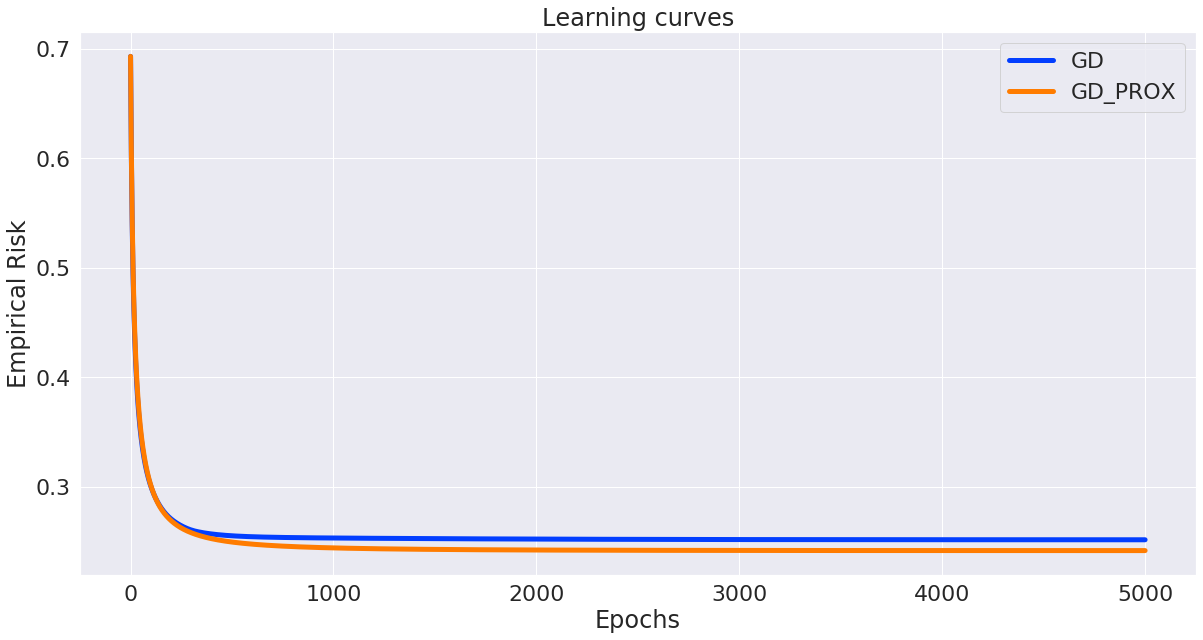

In [5]:
from lib.linear_model import LogisticRegression
from lib.visuals import learning_curve
clf_gd = LogisticRegression(solver='gd',l1=0.01,l2=0.01, max_iter=5000)
clf_gd.fit(A_train, b_train)

clf_gd_prox = LogisticRegression(solver='gd_prox',l1=0.01,l2=0.01, max_iter=5000)
clf_gd_prox.fit(A_train, b_train)


learning_curve(GD=clf_gd,GD_PROX=clf_gd_prox)

# SGD (Stochastic Gradient Descent)

At iteration k of the SGD algorithm, the following update is executed:

$$
\begin{cases}
i \textrm{ chosen randomly in } \{1...n\}\\
x_{k+1} \leftarrow x_{k} - \gamma_k \nabla f_i(x_k) \\
\end{cases}
$$

<div style="background-color: #e1f5fe;  border-left: 5px solid #2962ff; padding: 0.5em;"> 
<b style="color: #2962ff;">Question:</b>  
    <ul>
        <li> What stepsize $\gamma_k$ ensures the convergence of this algorithm and under what assumptions?</li>
        <li> Complete <b>TODO (5)</b></li>
        <li> Add your code to <b>\lib\solvers.py</b>.</li>
    </ul>
</div>

In [18]:
def SGD(x0, grad, prox, max_iter, n, L, mu):

    x = np.copy(x0)
    x_tab = np.copy(x)
    for k in range(max_iter):
        t = random.randrange(1, n)
        step = 1/(pow(k+1, 0.6))
        x = x - step*grad(x, t)
        # if k % n == 0:  # each completed epoch

        x_tab = np.vstack((x_tab, x))

    return x, x_tab



<div style="background-color: #e1f5fe;  border-left: 5px solid #2962ff; padding: 0.5em;"> 
<b style="color: #2962ff;">Question:</b> Run the code below to test your code.
</div>

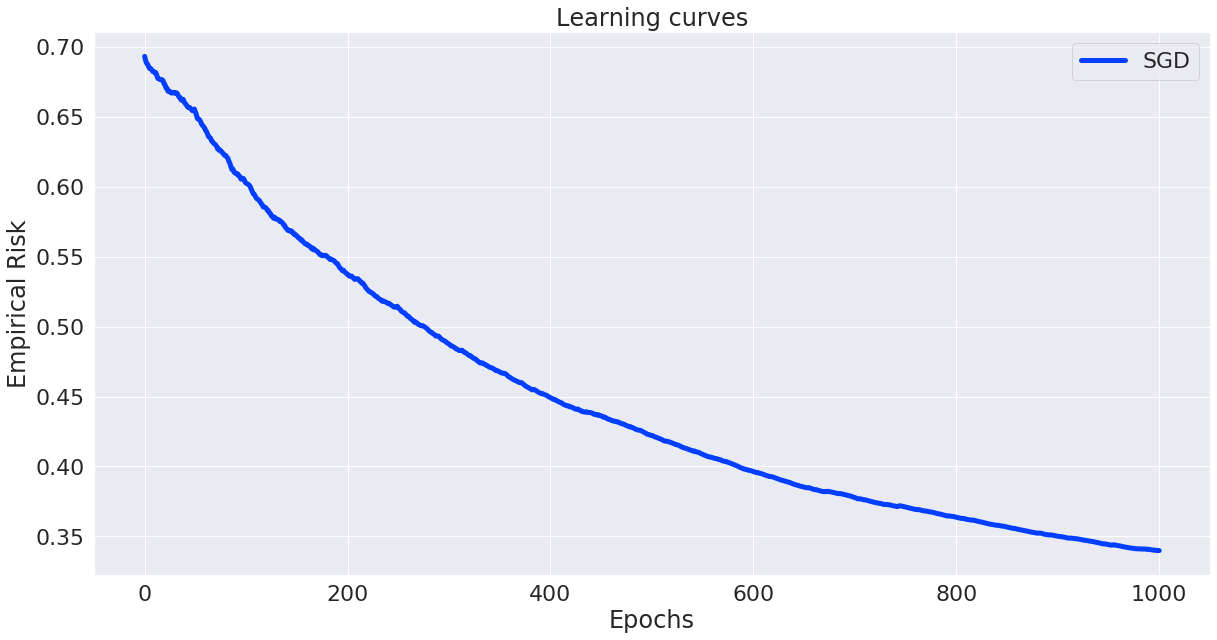

In [17]:
clf_sgd = LogisticRegression(solver='sgd',l2=0.01,max_iter=1000) #max_iter=100*len(b_train))
clf_sgd.fit(A_train, b_train)

learning_curve(SGD=clf_sgd)

# SAGA (Stochastic Average Gradient "Amélioré")

SAGA starts by computing a single batch gradient, then at iteration k, the following update is executed:

$$
\begin{cases}
i \textrm{ chosen randomly in } \{1...n\}\\
x_{k+1} \leftarrow x_{k} - \gamma_k\big(\nabla f_i(x_k) - \alpha_i + \bar{\alpha}\big) \\
\alpha_i \leftarrow \nabla f_i(x_{k+1}) 
\end{cases}
$$

where $(\alpha_j)_{j=1}^n$ are gradients evaluated at previous iterates and $\bar{\alpha}=\frac{1}{n}\sum^n_{j=1}\alpha_j$.


<div style="background-color: #e1f5fe;  border-left: 5px solid #2962ff; padding: 0.5em;"> 
<b style="color: #2962ff;">Question:</b>  
    <ul>
        <li> What stepsize $\gamma_k$ ensures the convergence of this algorithm and under what assumptions?</li>
        <li> Complete <b>TODO (6)</b></li>
        <li> Add your code to <b>\lib\solvers.py</b>.</li>
    </ul>
</div>

In [10]:
def SAGA(x0, grad, prox, max_iter, n, L, mu):

    x = np.copy(x0)
    x_tab = np.copy(x)
    d = len(x)

    A = np.zeros([n, d])
    #Initialize the table with the the gradients of the initial point x0
    for i in range(n):
        A[i, :] = grad(x, i)
    #Start the iterations
    for k in range(max_iter):
        step = 1/(pow(k+1, 0.01))
        #Draw randomly index j
        j = random.randrange(1, n)
        #Compute the average of all stored gradients from previous iterates
        alfa_bar = A.mean(0)
        
        #Update x
        x = x - step*(grad(x, j) - A[j, :] + alfa_bar)
        #Store the newly computed gradient on the table
        A[j, :] = grad(x, j)
        
        # if (k % n == 0):  # each completed epoch
        x_tab = np.vstack((x_tab, x))

    return x, x_tab


<div style="background-color: #e1f5fe;  border-left: 5px solid #2962ff; padding: 0.5em;"> 
<b style="color: #2962ff;">Question:</b> Run the code below to test your code.
</div>

In [18]:
clf_saga = LogisticRegression(solver='saga', l2=0.01,max_iter=5000) #max_iter=30*len(b_train))
clf_saga.fit(A_train, b_train)


learning_curve(SAGA_F=clf_saga,SAGA_1=clf_saga_1)




NameError: name 'clf_saga_1' is not defined

# SVRG (Stochastic Variance Reduced Gradient)

At iteration k of the SVRG algorithm, we perform the following:

$$
\begin{cases}
\textrm{Compute the batch gradient } \nabla f(x_k)\\
\textrm{Initialise }y_0 = x_k\\
\textrm{for m in 0...M-1: } 
\begin{cases}
i \textrm{ chosen randomly in } \{1...n\} \\
y_{m+1} \leftarrow y_{m} - \gamma_k\big(\nabla f_i(y_m) - \nabla f_i(x_k) + \nabla f(x_k)) 
\end{cases}\\
x_{k+1} \leftarrow y_{M}
\end{cases}
$$

<div style="background-color: #e1f5fe;  border-left: 5px solid #2962ff; padding: 0.5em;"> 
<b style="color: #2962ff;">Question:</b>  
    <ul>
        <li> What stepsize $\gamma_k$ ensures the convergence of this algorithm and under what assumptions?</li>
        <li> Complete <b>TODO (7)</b></li>
        <li> Add your code to <b>\lib\solvers.py</b>.</li>
    </ul>
</div>

In [ ]:
def SVRG(x0, grad, max_iter, n, L, mu):
    x = np.copy(x0)
    x_tab = np.copy(x)
    d = len(x)
    step =  1/(3*(mu*n+L))
    for k in range(max_iter):
         G=f_grad(x)
        y=x
        
        for i in range(2):
            e=random.randrange(1,n)
            g=f_grad_ex(y,e)-f_grad_ex(x,e)+G
            y=y-step*g
        x=y
        x_tab = np.vstack((x_tab, x))

    return x, x_tab

<div style="background-color: #e1f5fe;  border-left: 5px solid #2962ff; padding: 0.5em;"> 
<b style="color: #2962ff;">Question:</b> Run the code below to test your code.
</div>

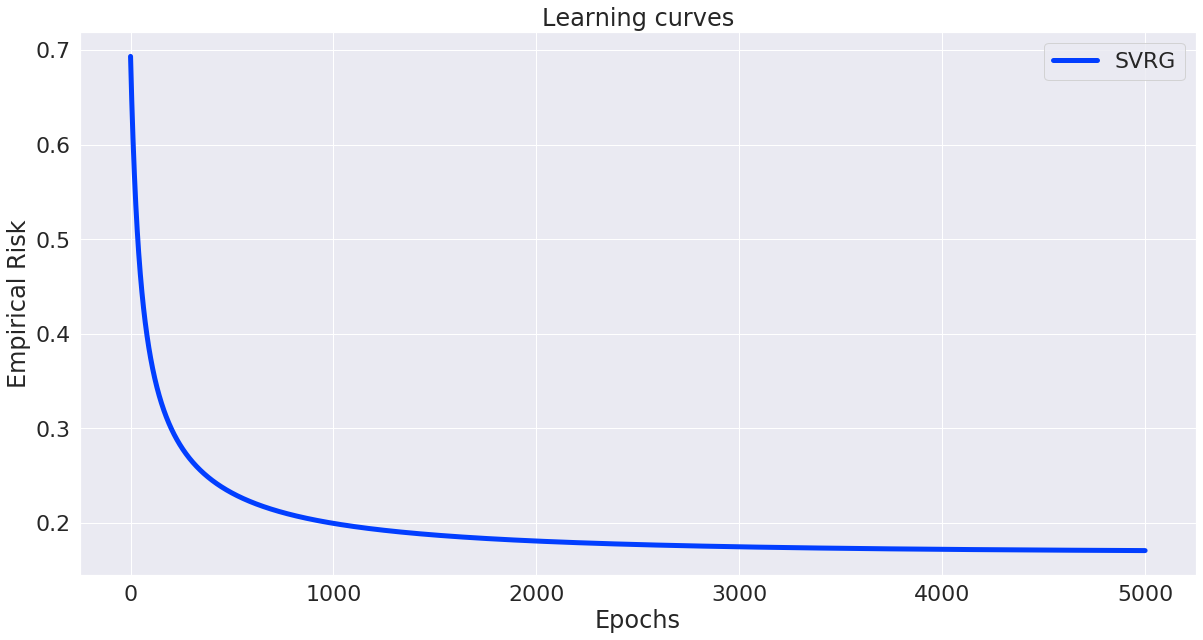

In [20]:
clf_svrg = LogisticRegression(solver='svrg', l2=0.01, max_iter=5000)
clf_svrg.fit(A_train, b_train)

learning_curve(SVRG=clf_svrg)


# Comparison

<div style="background-color: #e1f5fe;  border-left: 5px solid #2962ff; padding: 0.5em;"> 
<b style="color: #2962ff;">Question:</b> Run the code below to compare all the methods you've implemented.
</div>

In [21]:
epochs = 30
n = len(b_train)


clf_gd   = LogisticRegression(solver='gd',l1=0.01, l2=0.01, max_iter=n*epochs)
clf_gd_prox = LogisticRegression(solver='gd_prox',l1=0.01,l2=0.01,max_iter=n*epochs)
clf_sgd  = LogisticRegression(solver='sgd',l1=0.01, l2=0.01, max_iter=n*epochs)
clf_sgd_prox = LogisticRegression(solver='sgd_prox',l1=0.01, l2=0.01, max_iter=n*epochs)
clf_saga = LogisticRegression(solver='saga',l1=0.01, l2=0.01, max_iter=n*epochs)
clf_saga_prox = LogisticRegression(solver='saga_prox',l1=0.01,l2=0.01,max_iter=n*epochs)
clf_svrg = LogisticRegression(solver='svrg',l1=0.01, l2=0.01, max_iter=n*epochs)

clf_gd.fit(A_train, b_train)
clf_gd_prox.fit(A_train, b_train)
clf_sgd.fit(A_train, b_train)
clf_sgd
#clf_sgd_prox.fit(A_train,b_train)
clf_saga.fit(A_train, b_train)
#clf_saga_prox.fit(A_train,b_train)
clf_svrg.fit(A_train, b_train)

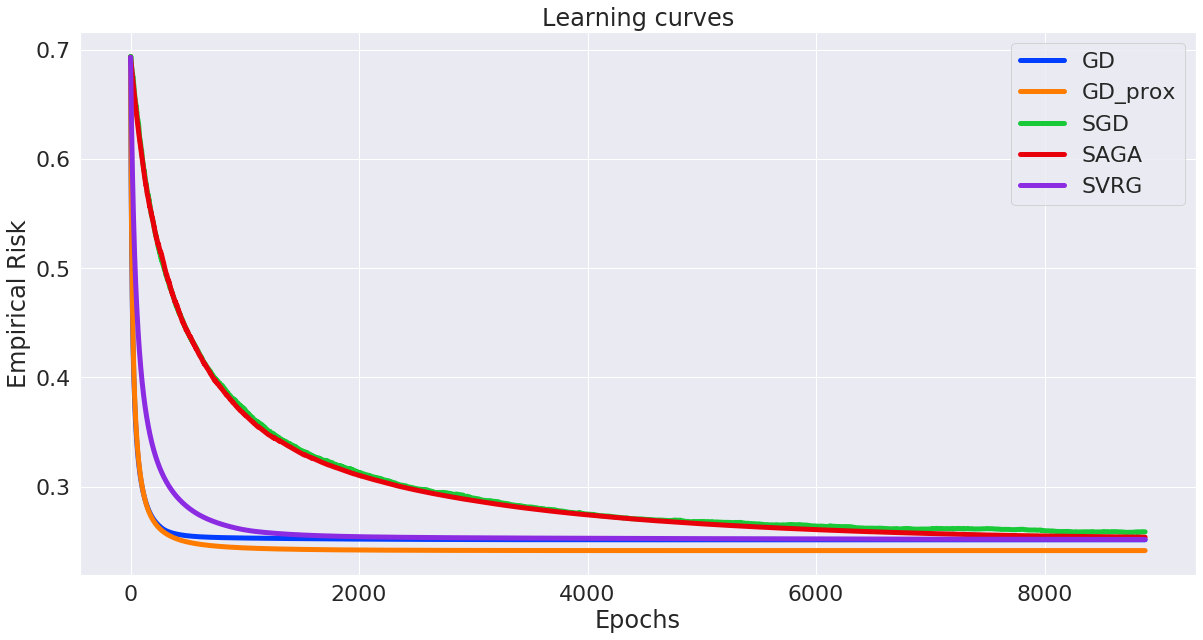

gd:	Accuracy on training set: 95.9%
	Accuracy on testing set:  86.9%
gd_proxsgd:	Accuracy on training set: 94.6%
	Accuracy on testing set:  88.9%
saga:	Accuracy on training set: 95.6%
	Accuracy on testing set:  86.9%
svrg:	Accuracy on training set: 95.3%
	Accuracy on testing set:  86.9%


In [22]:
learning_curve(GD=clf_gd,GD_prox=clf_gd_prox, SGD=clf_sgd, SAGA=clf_saga,SVRG=clf_svrg)

for clf, name in zip([clf_gd, clf_gd_prox, clf_sgd,clf_saga,clf_svrg], ['gd','gd_prox' 'sgd', 'saga', 'svrg']):
    print(name + ':' \
          + "\tAccuracy on training set: {0:0.1f}%".format(100*clf.score(A_train, b_train)))
    print("\tAccuracy on testing set:  {0:0.1f}%".format(100*clf.score(A_test, b_test)))

<br>
<div style="color: #ffffff; background-color: #2979ff; border-bottom: 5px solid #004ecb; padding: 2em;"> 
<h1>IV. Regularization</h1>
</div>

<div style="background-color: #e1f5fe;  border-left: 5px solid #2962ff; padding: 0.5em;"> 
<b style="color: #2962ff;">Question:</b> 
    <ul>
        <li> Rewrite the empirical risk minimization objective with both $L_1$ and $L_2$ regularization (with coefficients $l_1$ and $l_2$).</li>
        <li> Is this objective $\mu$-strongly convex, $L$-smooth, differentiable?</i>
        <li> Complete the <b>TODO (8)</b> to account for the new term in the objective.</i>
        <li> Add your code to <b>lib/linear_model.py</b>.</i>
    </ul>
</div>

> **Answer:**
>

```python
self._empirical_risk = lambda x: sum(self._logistic_loss(A, b, x))/n \
                                 + self.l2/2.0 * np.linalg.norm(x,2) \
                                 + self.l1 * np.linalg.norm(x,1)
```


The minimization algorithms we've implemented have a slow rate of convergence for this new objective function. We will therefore use *proximal* variations of these algorithms.

<div style="background-color: #e1f5fe;  border-left: 5px solid #2962ff; padding: 0.5em;"> 
<b style="color: #2962ff;">Question:</b> Using the $\textrm{prox}_{l_1 \|\cdot\|_1}$ operator, write down the $k^{th}$ step of proximal GD, proximal SGD, proximal SAGA, and proximal SVRG.
</div>

> **Answer:**
>

<div style="background-color: #e1f5fe;  border-left: 5px solid #2962ff; padding: 0.5em;"> 
<b style="color: #2962ff;">Question:</b> 
    <ul>
        <li> Give a closed-form expression of $\textrm{prox}_{l_1 \|\cdot\|_1}$</li>
        <li> Complete <b>TODO (9)</b> (note that you can access the $l_1$ coefficient using <b>self.l1</b>).</li>
        <li> Add your code to <b>\lib\linear_model.py</b>.</li>
    </ul>
</div>

> **Answer:**
>

In [ ]:
def prox(x,stepsize):
    p = np.zeros(n)
    for i in range(n):
        if x[i] < - l1*stepsize:
            p[i] = x[i] + l1*stepsize
        if x[i] > l1*stepsize:
            p[i] = x[i] - l1*stepsize
    return p

<div style="background-color: #e1f5fe;  border-left: 5px solid #2962ff; padding: 0.5em;"> 
<b style="color: #2962ff;">Question:</b> 
    <ul>
        <li> Add <b>prox</b> to the attributes of the solvers (both in the call to <b>self.solver</b> in <b>/lib/linear_model.py</b> and in <b>/lib/solvers.py</b>) as follows: <br> solver(x0, grad, <b>prox</b>, self.max_iter, n, L, mu)</li>
        <li> Add a proximal step to all the algorithms in <b>/lib/solvers.py</b>. </li>
        <li> Paste one of these algorithms in the cell bellow.</li>
    </ul>
</div>

In [ ]:
# def {GD or SGD or SAGA or SVRG}(x0, grad, prox, max_iter, n, L, mu):

<div style="background-color: #e1f5fe;  border-left: 5px solid #2962ff; padding: 0.5em;"> 
<b style="color: #2962ff;">Question:</b> If your proximal gradient descent is correctly implemented, the following cell will plot the support of the solution for various values of $l_1$.
    <ul>
        <li> Interpret the plot and explain what can $L_1$ regularization be used for.</li>
    </ul>
</div>

> **Answer:**
>

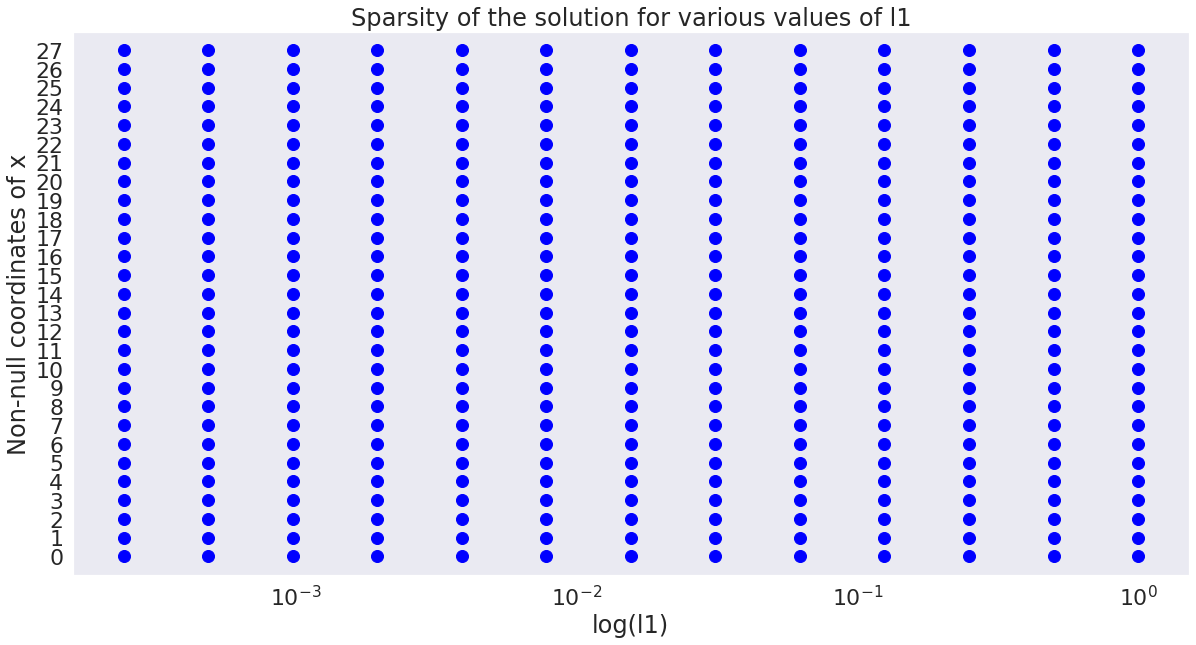

In [37]:
from lib.visuals import l1_regularization_plot

clf = lambda l1: LogisticRegression(solver='gd', l1=l1, l2=0.1, max_iter=1000)

l1_regularization_plot(clf, A_train, b_train)

<div style="background-color: #e1f5fe;  border-left: 5px solid #2962ff; padding: 0.5em;"> 
<b style="color: #2962ff;">Question:</b> The following cell will plot the value of the coordinates of the solution for various values of $l_2$.
    <ul>
        <li> Interpret the plot and explain what can $L_2$ regularization be used for.</li>
    </ul>
</div>

> **Answer:**
>

In [ ]:
from lib.visuals import l2_regularization_plot

clf = lambda l2: LogisticRegression(solver='gd', l1=0.01, l2=l2, max_iter=1000)

l2_regularization_plot(clf, A_train, b_train)

<br>
<div style="color: #ffffff; background-color: #2979ff; border-bottom: 5px solid #004ecb; padding: 2em;"> 
<h1>V. Further development</h1>
</div>

We expect that you go beyond the lab's questions and that you develop certain aspects of your work, depending on your personal interests and skills, for instance:
- Implementations and numerical tests (further developments, more experiments, etc.)
- Applications in learning or statistics (interpretation of some results, other models, other datasets, etc.)
- Theoretical or mathematical questions (convergence proofs, convergence rates, advanced versions of an algorithm, theoretical analysis of special cases, etc.) 

**Keyword ideas**: standard or stochastic Newton method, ADMM, continuation methods, tests on large scale datasets, intuition behind variance reduction, catalyst...